In [ ]:
# %load ../ionsrcopt/histogram_clustering.py
import pandas as pd
import numpy as np
import itertools
from statsmodels.stats.weightstats import DescrStatsW

def generate_density_histogram(df, columns, bins):
    """ From the supplied data generates a histogram, where the value of each bin indicates how many items lay inside, in percent. I.e summing over the whole histogram yields 1.

    Parameters:
        df (DataFrame)
        columns (list of string): The column name of which the joint histogram should be created
        bins (list): See numpy.histogramdd for more information

    Returns:
        H (multidimensional nparray): The values of every bin
        edges (list of nparray): Edges of the bins in every dimension
    """

    H, edges = np.histogramdd(df[columns].values, bins=bins, density=True)

    normalization_factor = np.prod([abs(edges[i][1] - edges[i][0]) for i in range(len(bins))])
    H = H * normalization_factor
    return H, edges

# Nearest neighbour clustering
def do_BFS_step(p, clusters, current_cluster, bins, histogram_values, threshold):
    """ One step of BFS. A bin in the histogram is considered a node in the underluying graph, if its value is above a certain threshold.

    Parameters:
        p (tuple of int): Histogram coordinates of the currently expanded node
        clusters (nparray): For each bin, indicating which cluster it belongs to. -1 if none. Gets altered if the bin at p is found to be in a cluster. Same dimension as histogram.
        current_cluster (int): index of the currently searched cluster
        bins (list)
        histogram_values (nparray): Histogram values
        threshold (double): Every bin below this threshold will be discarded as noise

    Returns
        list of tuple of int: All children of p, but not necessarily nodes in the underlying graph.
    """

    result = []
    if clusters[p] >= 0 or histogram_values[p] < threshold: # Node has to be ignored. Else assign to cluster and find children.
        return result
    
    clusters[p] = current_cluster
    for i in range(len(p)):
        if p[i] > 0:
            child = list(p)
            child[i] -= 1
            result.append(tuple(child))
        if p[i] + 1 < bins[i]:
            child = list(p)
            child[i] += 1
            result.append(tuple(child))
    return result

def nearest_neighbour_clustering(histogram_values, bins, density_threshold):
    """ Searches for clusters in the given histogram, where all bins with a density below the threshold are discarded as noise. For clustering BFS is used, i.e. clusters are connected components of the underlying graph.

    Parameters:
        histogram_values (nparray): The values of every bin.
        bins (list)
        density_threshold (double): Every bin below this threshold will be discarded as noise

    Returns:
        nparray of int: For every bin in the histogram, returns which cluster it belongs to, or -1 if none.
    """

    clusters = np.ones(bins)
    clusters *= -1
    current_cluster = 0

    l = [range(b) for b in bins]
    perms = list(itertools.product(*l))
    for p in perms:
        if clusters[p] >= 0 or histogram_values[p] < density_threshold:
            continue
        
        print("Started search for cluster {}".format(current_cluster))
        nodes_to_check = do_BFS_step(p, clusters, current_cluster, bins, histogram_values, density_threshold)
        while len(nodes_to_check) > 0:
            node = nodes_to_check.pop(0)
            nodes_to_check.extend(do_BFS_step(tuple(node), clusters, current_cluster, bins, histogram_values, density_threshold))
        
        current_cluster += 1

    print("Found {} cluster(s)".format(current_cluster))
    return clusters

def create_cluster_frame(histogram_edges, histogram_values, bins, clusters, columns, cluster_column_name='CLUSTER'): 
    """ Constructs a Data Frame from a histogram and cluster results

    Parameters:
        histogram_edges (list of nparray): Edges of the bins in every dimension
        histogram_values (nparray): The values of every bin.
        bins (list)
        clusters (list of int): cluster, to which every bin belongs to
        columns (list of string): column names of clustered data
        cluster_column_name (string): column name of the cluster result

    Returns:
        DataFrame: A frame that contains density and cluster information about every bin
    """
    
    l = [range(b) for b in bins]
    perms = list(itertools.product(*l))
    values = [[(histogram_edges[i][perm[i]] + histogram_edges[i][perm[i]+1])*0.5 for i in range(len(bins))] + [histogram_values[perm], clusters[perm]] for perm in perms]
    clustered = pd.DataFrame(values, columns=columns + ['DENSITY', cluster_column_name])
    return clustered


def describe_cluster(cluster, columns):
    """ Generate descriptive statistics for a cluster

    Parameters:
        cluster (DataFrame): A dataframe, that contains density informations for every bin in the cluster
        columns (list of string): The names of the columns for which to generate statistics

    Returns: 
        Series: All statistics for the selected columns
    """

    values = cluster.values
    dstats = DescrStatsW(values, cluster['DENSITY'].values if len(values) > 1 else None)
    mean = dstats.mean
    std = dstats.std
    quantiles = dstats.quantile(0.5, return_pandas=False)
    
    result_columns = [[mean[i], std[i], cluster[columns[i]].min(), quantiles[0][i], cluster[columns[i]].max()] for i in range(len(columns))]
    result = list(itertools.chain(*result_columns)) + [cluster['DENSITY'].count(), cluster['DENSITY'].sum()]
    
    value_columns = [[(col, 'mean'), (col, 'std'), (col, 'min'), (col, 'median'), (col, 'max')] for col in columns]
    index = list(itertools.chain(*value_columns)) + [('DENSITY', 'count'), ('DENSITY', 'total')]
    
    return pd.Series(result, index=pd.MultiIndex.from_tuples(index))


def describe_clusters(df, columns):
    """ Summarize all clusters and sort them by density

    Parameters:
        df (DataFrame): A frame containing density and cluster information about every bin
        columns (list of string): The names of the columns for which to generate statistics
    
    Returns:
        DataFrame: Descriptive frame sorted by density
    """

    result = df.groupby('CLUSTER').apply(describe_cluster, columns)
    return result.sort_values(('DENSITY', 'total'), ascending=0)

In [ ]:
# %load ../ionsrcopt/load_data.py
import pandas as pd

def read_data_from_csv(filename, cols_to_read, rows_to_read):
    """ Read a csv file into a DataFrame

    Parameters:
        filename (string): Filename
        cols_to_read (list of string): The column names to read, None if everything should be read
        rows_to_read (list of int): The rown numbers to read, None if everything should be read

    Returns:
        DataFrame
    """

    print("Loading data from csv file \'{}\'".format(filename))
    if cols_to_read is None:
        df = pd.read_csv(filename).fillna(method='ffill')
    else:
        df = pd.read_csv(filename, usecols=cols_to_read).fillna(method='ffill')

    if rows_to_read is None:
        return df
    else:
        return df.iloc[rows_to_read]

def convert_column(df, column, type):
    """ Converts the dtype of a column

    Parameters:
        df (DataFrame): The DataFrame containing the column
        column (string): The column name
        type (string): dtype the column should be converted to

    Returns:
        DataFrame: The altered DataFrame or the old one, if it did not contain the specified column
    """

    if column in df.columns:
        print("Converting column \'{}\' to \'{}\'".format(column, type))
        return df.astype({column:type})
    else:
        print("Column \'{}\' does not exist".format(column))
        return df

def convert_column_types(df):
    """ Convert all columns of a Dataframe of measurements to single precision values.

    Parameters:
        df (DataFrame): DataFrame to be altered

    Returns:
        DataFrame
    """

    print("Started type conversion of columns...")
    df = convert_column(df, 'IP.NSRCGEN:BIASDISCAQNV', 'float32')
    df = convert_column(df, 'IP.NSRCGEN:GASSASAQN', 'float32')
    df = convert_column(df, 'IP.NSRCGEN:SOURCEHTAQNI', 'float32')
    df = convert_column(df, 'IP.SAIREM2:FORWARDPOWER', 'float32')
    df = convert_column(df, 'SOLCEN.ACQUISITION:CURRENT', 'float32')
    df = convert_column(df, 'IP.SOLEXT.ACQUISITION:CURRENT', 'float32')
    df = convert_column(df, 'IP.SOLINJ.ACQUISITION:CURRENT', 'float32')
    df = convert_column(df, 'ITF.BCT15:CURRENT', 'float32')
    df = convert_column(df, 'ITF.BCT25:CURRENT', 'float32')
    df = convert_column(df, 'ITH.BCT41:CURRENT', 'float32')
    df = convert_column(df, 'ITL.BCT05:CURRENT', 'float32')
    return df


def clean_data(df):
    """ Clean the data of measurements, that are outliers, e.g. spikes in the extraction current.

    Parameters:
        df (DataFrame): DataFrame containing the measurements.

    Returns:
        DataFrame: Cleaned data.
    """

    print("Filtering data...")
    df.dropna(inplace=True)
    if 'ITF.BCT15:CURRENT' in df.columns:
        df.drop(df[df['ITF.BCT15:CURRENT'] < 0].index, inplace=True)
    if 'ITF.BCT25:CURRENT' in df.columns:
        df.drop(df[df['ITF.BCT25:CURRENT'] < 0].index, inplace=True)
    if 'ITH.BCT41:CURRENT' in df.columns:
        df.drop(df[df['ITH.BCT41:CURRENT'] < 0].index, inplace=True)
    if 'ITL.BCT05:CURRENT' in df.columns:
        df.drop(df[df['ITL.BCT05:CURRENT'] < 0].index, inplace=True)
    if 'IP.NSRCGEN:OVEN1AQNP' in df.columns:
        df.drop(df[df['IP.NSRCGEN:OVEN1AQNP'] < 4.5].index, inplace=True)
    if 'IP.SOLEXT.ACQUISITION:CURRENT' in df.columns:
        df.drop(df[df['IP.SOLEXT.ACQUISITION:CURRENT'] < 1200].index, inplace=True)
    if 'IP.NSRCGEN:BIASDISCAQNV' in df.columns:
        df.drop(df[df['IP.NSRCGEN:BIASDISCAQNV'] == 0].index, inplace=True)
    if 'IP.SAIREM2:FORWARDPOWER' in df.columns:
        df.drop(df[df['IP.SAIREM2:FORWARDPOWER'] < 500].index, inplace=True)
    if 'IP.NSRCGEN:SOURCEHTAQNI' in df.columns:
        df.drop(df[df['IP.NSRCGEN:SOURCEHTAQNI'] > 2.5].index, inplace=True)
    if 'IP.NSRCGEN:SOURCEHTAQNI' in df.columns:
        df.drop(df[df['IP.NSRCGEN:SOURCEHTAQNI'] < 0.5].index, inplace=True)
    
    return df

### Multivariate normal that streches in the x and y directions

In [72]:
mean = [0,0,0]
cov = [[10, 0, 0], [0, 10, 0], [0, 0, 0.1]]
x, y, z = np.random.multivariate_normal(mean, cov, 250000).T
df = pd.DataFrame({'X':x, 'Y':y, 'Z':z})

### Two multivariate normals
One streching in x and y direction, and in y and z direction with an offset mean in z direction

In [18]:
mean1 = [0,0,0]
cov1 = [[10, 0, 0], [0, 10, 0], [0, 0, 0.1]]
x1, y1, z1 = np.random.multivariate_normal(mean1, cov1, 250000).T

In [47]:
mean2 = [0,0,10]
cov2 = [[0.1, 0, 0], [0, 5, 0], [0, 0, 5]]
x2, y2, z2 = np.random.multivariate_normal(mean2, cov2, 250000).T

In [48]:
df = pd.DataFrame({'X':np.concatenate((x1, x2)), 'Y':np.concatenate((y1, y2)), 'Z': np.concatenate((z1, z2))})
df.shape

(500000, 3)

### Two multivariate normals without offset
One streching in x and y direction, and in y and z direction, both with mean 0

In [53]:
mean1 = [0,0,0]
cov1 = [[10, 0, 0], [0, 10, 0], [0, 0, 0.1]]
x1, y1, z1 = np.random.multivariate_normal(mean1, cov1, 250000).T

In [54]:
mean2 = [0,0,0]
cov2 = [[0.1, 0, 0], [0, 5, 0], [0, 0, 5]]
x2, y2, z2 = np.random.multivariate_normal(mean2, cov2, 250000).T

In [55]:
df = pd.DataFrame({'X':np.concatenate((x1, x2)), 'Y':np.concatenate((y1, y2)), 'Z': np.concatenate((z1, z2))})
df.shape

(500000, 3)

### Multivariate normal with non diagonal covariance matrix

In [66]:
mean = [0,0,0]
cov = [[2.5, 1, 0], [1, 5, 0], [0, 0, 1]]
x, y, z = np.random.multivariate_normal(mean, cov, 250000).T

In [68]:
df = pd.DataFrame({'X':x, 'Y':y, 'Z':z})
df.shape

(250000, 3)

### Real Source Data
#### BiasDisc vs Gas

In [4]:
df = read_data_from_csv('../Data_Raw/Nov2018.csv', ['IP.NSRCGEN:BIASDISCAQNV', 'IP.NSRCGEN:GASSASAQN'], None)
df = convert_column_types(df)
df = clean_data(df)
df.columns = ['X', 'Y']
df.shape

Loading data from csv file '../Data_Raw/Nov2018.csv'
Started type conversion of columns...
Converting column 'IP.NSRCGEN:BIASDISCAQNV' to 'float32'
Converting column 'IP.NSRCGEN:GASSASAQN' to 'float32'
Column 'IP.NSRCGEN:SOURCEHTAQNI' does not exist
Column 'IP.SAIREM2:FORWARDPOWER' does not exist
Column 'SOLCEN.ACQUISITION:CURRENT' does not exist
Column 'IP.SOLEXT.ACQUISITION:CURRENT' does not exist
Column 'IP.SOLINJ.ACQUISITION:CURRENT' does not exist
Column 'ITF.BCT15:CURRENT' does not exist
Column 'ITF.BCT25:CURRENT' does not exist
Column 'ITH.BCT41:CURRENT' does not exist
Column 'ITL.BCT05:CURRENT' does not exist
Filtering data...


(2845267, 2)

#### BiasDisc vs Oven

In [93]:
df = read_data_from_csv('../Data_Raw/Nov2018.csv', ['IP.NSRCGEN:GASSASAQN', 'ITL.BCT05:CURRENT'], None) #['IP.NSRCGEN:BIASDISCAQNV', 'IP.NSRCGEN:OVEN1AQNP'], None)
df = convert_column_types(df)
df = clean_data(df)
df.columns = ['X', 'Y']
df.shape

Loading data from csv file '../Data_Raw/Nov2018.csv'
Started type conversion of columns...
Column 'IP.NSRCGEN:BIASDISCAQNV' does not exist
Converting column 'IP.NSRCGEN:GASSASAQN' to 'float32'
Column 'IP.NSRCGEN:SOURCEHTAQNI' does not exist
Column 'IP.SAIREM2:FORWARDPOWER' does not exist
Column 'SOLCEN.ACQUISITION:CURRENT' does not exist
Column 'IP.SOLEXT.ACQUISITION:CURRENT' does not exist
Column 'IP.SOLINJ.ACQUISITION:CURRENT' does not exist
Column 'ITF.BCT15:CURRENT' does not exist
Column 'ITF.BCT25:CURRENT' does not exist
Column 'ITH.BCT41:CURRENT' does not exist
Converting column 'ITL.BCT05:CURRENT' to 'float32'
Filtering data...


(2843783, 2)

### Plotting the sample data
#### 2D Plot

In [5]:
bins = [100, 100] 
cols_to_cluster = ['X', 'Y']
H, edges = generate_density_histogram(df, cols_to_cluster, bins)

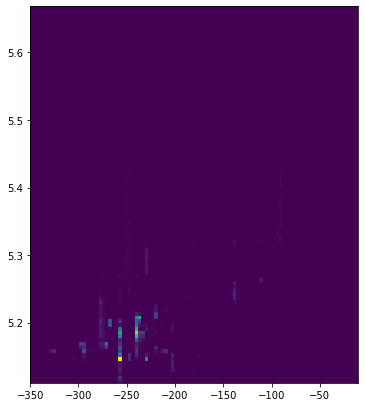

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"] = (20,20)


fig = plt.figure()
ax = fig.add_subplot(132)
ax.set_aspect('700')
X, Y = np.meshgrid(edges[0], edges[1])
ax.pcolormesh(X, Y, H.T)

plt.show()

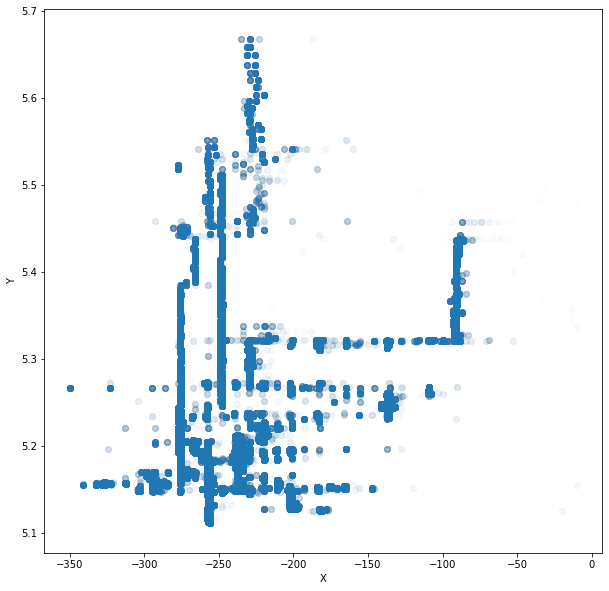

In [7]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

fig = plt.figure()
ax = fig.add_subplot()

ax.scatter(df['X'], df['Y'], marker='o', alpha=0.01)

ax.set_xlabel('X')
ax.set_ylabel('Y')

plt.show()

#### 3D Plot

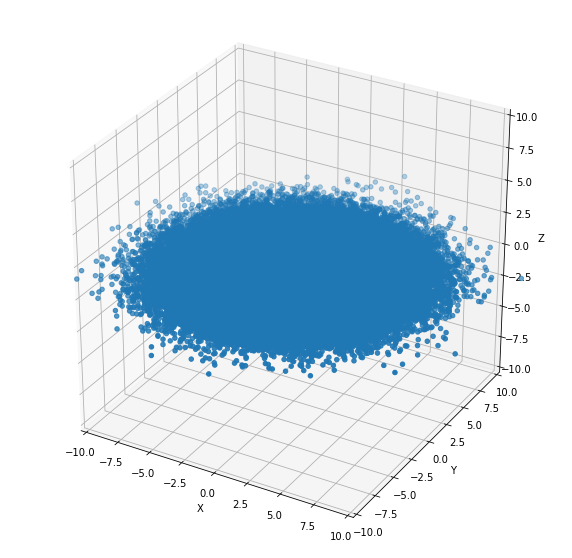

In [74]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"] = (10,10)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df['X'], df['Y'], df['Z'], marker='o')

ax.set_xlabel('X')
ax.set_xlim(-10, 10)
ax.set_ylabel('Y')
ax.set_ylim(-10, 10)
ax.set_zlabel('Z')
ax.set_zlim(-10, 10)

plt.show()

### Clustering using Nearest Neighbour Clustering

In [15]:
hist_mean = np.mean(H)
hist_std = np.std(H)
threshold = hist_mean+hist_std
threshold

0.001379213249352001

In [16]:
clusters = nearest_neighbour_clustering(H, bins, threshold)
cl_df = create_cluster_frame(edges, H, bins, clusters, cols_to_cluster)

Started search for cluster 0
Started search for cluster 1
Started search for cluster 2
Started search for cluster 3
Started search for cluster 4
Started search for cluster 5
Started search for cluster 6
Started search for cluster 7
Started search for cluster 8
Started search for cluster 9
Started search for cluster 10
Started search for cluster 11
Started search for cluster 12
Started search for cluster 13
Started search for cluster 14
Started search for cluster 15
Started search for cluster 16
Started search for cluster 17
Started search for cluster 18
Started search for cluster 19
Started search for cluster 20
Started search for cluster 21
Started search for cluster 22
Started search for cluster 23
Started search for cluster 24
Found 25 cluster(s)


In [47]:
describe_clusters(cl_df, cols_to_cluster)

X                                            Y            \
               mean           std    min median    max      mean       std   
CLUSTER                                                                      
 9.0    -238.327580  1.998138e+00 -239.5 -239.5 -232.7  5.189949  0.014206   
 5.0    -256.500000  0.000000e+00 -256.5 -256.5 -256.5  5.162844  0.020762   
-1.0    -220.885290  6.150929e+01 -348.3 -246.3  -11.7  5.279549  0.105118   
 3.0    -276.177301  1.391001e+00 -276.9 -276.9 -273.5  5.203323  0.017265   
 1.0    -294.917386  1.556932e+00 -297.3 -293.9 -293.9  5.163765  0.005500   
 2.0    -271.435320  2.267599e+00 -276.9 -270.1 -270.1  5.167961  0.002483   
 10.0   -229.300000  2.842171e-14 -229.3 -229.3 -229.3  5.147956  0.001902   
 4.0    -266.700000  0.000000e+00 -266.7 -266.7 -266.7  5.200228  0.002783   
 16.0   -219.100000  2.842171e-14 -219.1 -219.1 -219.1  5.213518  0.004978   
 20.0   -137.500000  0.000000e+00 -137.5 -137.5 -137.5  5.247031  0.008178   
 12.0   -229.300000  0.000000e+00 -229.3 -229.3 -229.3  5.291464  0.011060   
 18.0   -202.100000  0.000000e+00 -202.1 -202.1 -202.1  5.142106  0.007991   
 7.0    -246.300000  0.000000e+00 -246.3 -246.3 -246.3  5.150189  0.002778   
 17.0   -210.300000  1.673320e+00 -212.3 -208.9 -208.9  5.158345  0.000000   
 0.0    -325.910494  1.675168e+00 -327.9 -324.5 -324.5  5.158345  0.000000   
 14.0   -219.100000  2.842171e-14 -219.1 -219.1 -219.1  5.162215  0.002565   
 6.0    -256.500000  0.000000e+00 -256.5 -256.5 -256.5  5.202905  0.000000   
 19.0   -202.100000  0.000000e+00 -202.1 -202.1 -202.1  5.194146  0.002756   
 11.0   -229.300000  0.000000e+00 -229.3 -229.3 -229.3  5.193584  0.002612   
 22.0   -110.300000  0.000000e+00 -110.3 -110.3 -110.3  5.264175  0.000000   
 21.0   -137.500000  0.000000e+00 -137.5 -137.5 -137.5  5.319875  0.000000   
 23.0    -89.900000  0.000000e+00  -89.9  -89.9  -89.9  5.325445  0.000000   
 15.0   -219.100000  0.000000e+00 -219.1 -219.1 -219.1  5.186195  0.000000   
 13.0   -222.500000  0.000000e+00 -222.5 -222.5 -222.5  5.191765  0.000000   
 24.0    -89.900000  0.000000e+00  -89.9  -89.9  -89.9  5.347725  0.000000   
 8.0    -246.300000  0.000000e+00 -246.3 -246.3 -246.3  5.247465  0.000000   

                                      DENSITY            
              min    median       max   count     total  
CLUSTER                                                  
 9.0     5.152775  5.186195  5.214045    22.0  0.308709  
 5.0     5.113785  5.158345  5.191765    15.0  0.208476  
-1.0     5.113785  5.264175  5.665215  9890.0  0.128611  
 3.0     5.180625  5.202905  5.236325    17.0  0.052501  
 1.0     5.152775  5.163915  5.169485     6.0  0.044433  
 2.0     5.163915  5.169485  5.169485     5.0  0.040574  
 10.0    5.147205  5.147205  5.152775     2.0  0.029542  
 4.0     5.197335  5.202905  5.202905     2.0  0.025886  
 16.0    5.208475  5.214045  5.225185     4.0  0.024397  
 20.0    5.236325  5.247465  5.258605     5.0  0.021691  
 12.0    5.275315  5.292025  5.308735     7.0  0.020844  
 18.0    5.130495  5.141635  5.152775     5.0  0.019697  
 7.0     5.147205  5.152775  5.152775     2.0  0.013557  
 17.0    5.158345  5.158345  5.158345     2.0  0.012075  
 0.0     5.158345  5.158345  5.158345     2.0  0.010422  
 14.0    5.158345  5.163915  5.163915     2.0  0.008079  
 6.0     5.202905  5.202905  5.202905     1.0  0.007116  
 19.0    5.191765  5.191765  5.197335     2.0  0.004921  
 11.0    5.191765  5.191765  5.197335     2.0  0.004528  
 22.0    5.264175  5.264175  5.264175     1.0  0.003901  
 21.0    5.319875  5.319875  5.319875     1.0  0.002441  
 23.0    5.325445  5.325445  5.325445     1.0  0.001677  
 15.0    5.186195  5.186195  5.186195     1.0  0.001536  
 13.0    5.191765  5.191765  5.191765     1.0  0.001490  
 24.0    5.347725  5.347725  5.347725     1.0  0.001449  
 8.0     5.247465  5.247465  5.247465     1.0  0.001445